In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

# Veri setini yükleme
data = pd.read_csv('/Users/anilturkmen/Desktop/Akbank_prje/bist100_stocks_2020_2024.csv')

# Verinin ilk birkaç satırını gözlemleyelim
print(data.head())


                        Date      Open      High       Low     Close  \
0  2020-01-02 00:00:00+03:00  6.706947  6.731575  6.665901  6.715157   
1  2020-01-03 00:00:00+03:00  6.665901  6.674111  6.485298  6.534554   
2  2020-01-06 00:00:00+03:00  6.411415  6.452461  6.288276  6.329322   
3  2020-01-07 00:00:00+03:00  6.386787  6.452461  6.370369  6.394996   
4  2020-01-08 00:00:00+03:00  6.312904  6.550972  6.288276  6.534554   

     Volume  Dividends  Stock Splits    Ticker  
0  21596781        0.0           0.0  AKBNK.IS  
1  26669857        0.0           0.0  AKBNK.IS  
2  25871931        0.0           0.0  AKBNK.IS  
3  17681865        0.0           0.0  AKBNK.IS  
4  32090537        0.0           0.0  AKBNK.IS  


In [31]:
# Hangi hisse senedi üzerinde çalışacağımızı seçelim (örneğin AKBNK.IS)
ticker = "KCHOL.IS"
stock_data = data[data['Ticker'] == ticker]

# Tarihi indeks olarak ayarlayalım ve sadece kapanış fiyatlarını alalım
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.set_index('Date', inplace=True)
close_prices = stock_data['Close'].values.reshape(-1, 1)

# Veriyi ölçeklendirelim (MinMaxScaler kullanarak)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

# Eğitim ve test setlerini oluşturalım
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Zaman serisi verisini LSTM modeline uygun hale getirelim
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# LSTM girişleri için veriyi yeniden şekillendirelim [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


/var/folders/jd/m96sy9cd07bgckxgxc2ggj840000gn/T/ipykernel_45107/2635231951.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Date'] = pd.to_datetime(stock_data['Date'])


In [32]:
# Modeli oluşturma
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Modeli derleme
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Modeli eğitme
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/20


/opt/anaconda3/envs/my_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0067 - val_loss: 0.0020
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.6672e-04 - val_loss: 0.0043
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.4882e-04 - val_loss: 0.0031
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.3584e-04 - val_loss: 0.0024
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.1443e-04 - val_loss: 0.0017
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.6860e-04 - val_loss: 0.0021
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.6031e-04 - val_loss: 0.0022
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.3731e-04 - val_loss: 0.0024
Epoch 9/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.6115e-04 - val_loss: 0.0026
Epoch 10/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.3607e-04 - val_loss: 0.0036
Epoch 11/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.3681e-04 - val_loss: 0.0020
Epoch 12/20
26/26 ━━━━━━━━━━━━━━━━

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Train RMSE: 2.7107904202276734
Test RMSE: 10.689341638351104


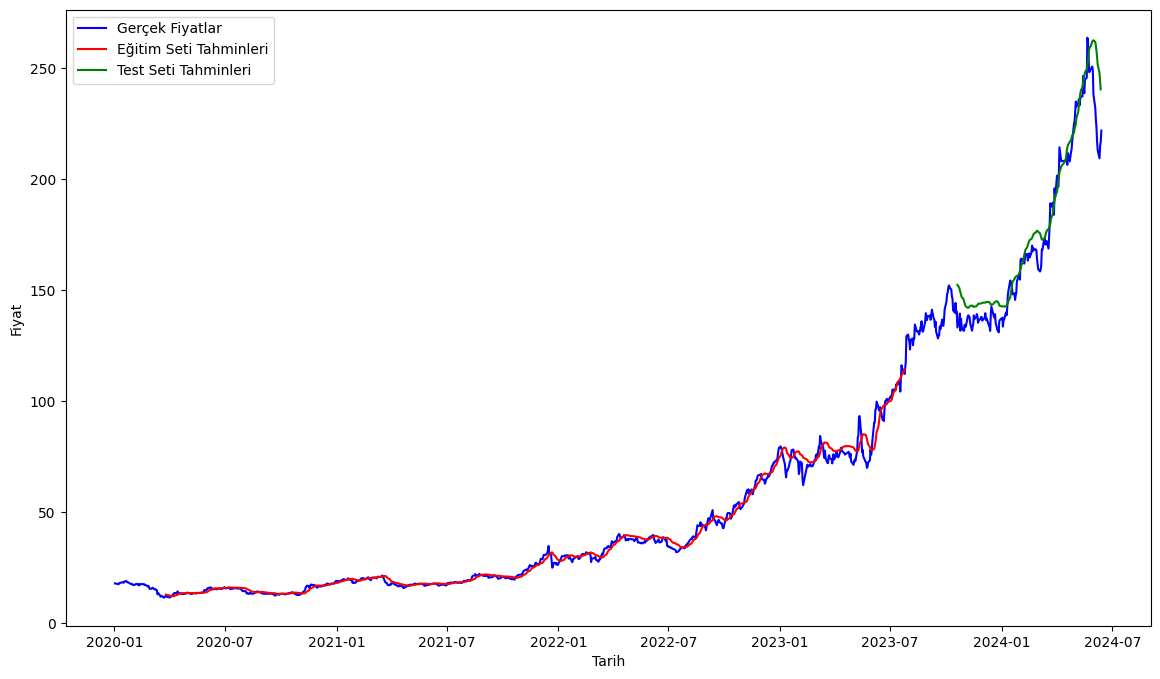

In [33]:
# Modelin performansını değerlendirme
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Tahminleri geri ölçeklendirme
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Modelin performansını metriklerle değerlendirme
import math
from sklearn.metrics import mean_squared_error

train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

# Tahminleri ve gerçek değerleri görselleştirme
plt.figure(figsize=(14, 8))
plt.plot(stock_data.index, close_prices, color='blue', label='Gerçek Fiyatlar')
plt.plot(stock_data.index[time_step:len(train_predict) + time_step], train_predict, color='red', label='Eğitim Seti Tahminleri')
plt.plot(stock_data.index[len(train_predict) + (time_step * 2) + 1:len(scaled_data) - 1], test_predict, color='green', label='Test Seti Tahminleri')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.legend()
plt.show()


In [26]:
# Eğitilen modeli kaydedelim
model.save('lstm_stock_modelISCTR.h5')


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


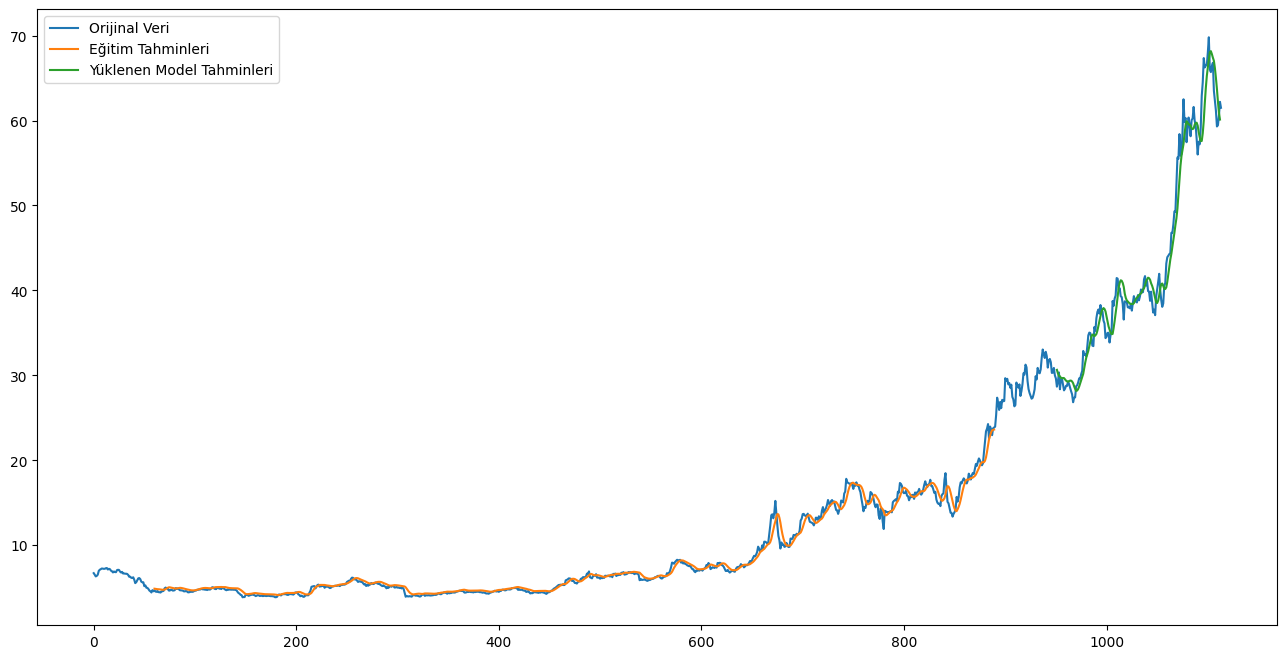

In [7]:
from keras.models import load_model

# Modeli yükleyelim
loaded_model = load_model('lstm_stock_model.h5')

# Yüklenen model ile tahmin yapalım (örneğin test verisi üzerinde)
loaded_model_predict = loaded_model.predict(X_test)

# Veriyi orijinal ölçeğe geri dönüştürelim
loaded_model_predict = scaler.inverse_transform(loaded_model_predict)

# Sonuçları görselleştirelim
plt.figure(figsize=(16,8))
plt.plot(scaler.inverse_transform(scaled_data), label='Orijinal Veri')
plt.plot(np.arange(time_step, time_step+len(train_predict)), train_predict, label='Eğitim Tahminleri')
plt.plot(np.arange(len(train_predict)+(2*time_step)+1, len(scaled_data)-1), loaded_model_predict, label='Yüklenen Model Tahminleri')
plt.legend()
plt.show()
